CNN para Detecção/Diagnóstico de Falhas
--------------------------------------------------------


O objetivo do trabalho é usar os sinais produzidos pelo simulador do Tennessee Eastman (TE)
para detectar uma falha e/ou diagnosticar qual falha ocorreu


Dados: Os arquivos pré-divididos 'd00.dat, d00_te.dat', ..., 'd21.dat d21_te.dat'


00 = Normalidade

xx = Falha xx


xx.dat (exceto 00.dat) contém dados da falha

xx_te.dat contém 160 amostras de normalidade, depois o resto da falha


O arquivo TE.py já contém muita funcionalidade necessária (ler arquivo, visualizar sinal, ...)





Deve usar uma rede CNN para montar o sistema.


Avaliação por validação cruzada 5-fold.

In [1]:
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import models, layers, losses, regularizers, callbacks, constraints, optimizers
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

2023-01-12 08:19:09.050774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 08:19:09.764857: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-12 08:19:09.885956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-12 08:19:09.885982: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
def normalize(d):
  media_treino = d.mean(axis=0)
  std_treino = d.std(axis=0, ddof=0)
  d = d - media_treino
  d = d/std_treino
  return d

def get_entradas_labels_treino(dados_normais, falha_treino, colunas):

  # seleciona e lê o i-ésimo arquivo de falha   
  dfalha_i = pd.read_csv(falha_treino, delim_whitespace=True, header=None)
  dfalha_i['falha'] = np.ones(len(dfalha_i), dtype='int')*1 # 1
  # concatena os dados normais com os dados de falha
  dtreino = pd.concat([dados_normais, dfalha_i]) 
  X = dtreino[colunas].values
  labels_treino = dtreino['falha'].values
  # shape (X, 13, 2, 2) de acordo o padrão esperado por uma cnn
  X = X.reshape(len(X), 13, 2, 2)
  labels_treino = labels_treino.reshape(len(labels_treino), 1)
  # normaliza os dados de treino
  X = normalize(X)
  
  return X, labels_treino

def get_entradas_labels_teste(falha_teste, colunas):
  ### dados de teste
  dte = pd.read_csv(falha_teste, delim_whitespace=True, header=None)
  dte['falha'] = np.ones(len(dte), dtype='int')*1
  # primeiros 160 são dados de normalidade
  dte.loc[np.arange(160), 'falha'] = 0

  X_teste = dte[colunas].values
  labels_teste = dte['falha'].values
  # apenas para manter o padrão entre 0 e 1
  labels_teste = labels_teste/np.max(labels_teste)
  X_teste = normalize(X_teste)
  X_teste = X_teste.reshape(len(X_teste), 13, 2, 2)
  return X_teste, labels_teste

def plot_falha(falha_treino):
  dfalha_i = pd.read_csv(falha_treino, delim_whitespace=True, header=None)
  dfalha_i['falha'] = np.ones(len(dfalha_i), dtype='int')*1 # 1
  dfalha_i[[0,1,2]].plot()

In [3]:
# todos os arquivos
arquivos = glob.glob('data/*.dat')
# arquivos de teste
arquivos_teste = sorted(glob.glob('data/*te.dat'))
# arquivos de treino (falha)
arquivos_treino = sorted(list(set(arquivos).difference(arquivos_teste)))

In [19]:
dfalha_i = pd.read_csv(arquivos_treino[3], delim_whitespace=True, header=None)
dfalha_i['falha'] = np.ones(len(dfalha_i), dtype='int')*1 # 1

In [20]:
dfalha_i

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,falha
0,0.25695,3637.2,4483.4,9.2595,27.269,42.631,2705.0,74.757,120.42,0.33301,80.183,48.265,2633.5,26.132,48.587,3103.0,23.262,65.783,231.55,340.83,94.607,77.584,32.303,8.8775,26.709,6.8919,18.499,1.6858,33.316,13.940,24.119,1.3400,18.520,2.2422,4.9278,2.2223,0.037789,0.84539,0.088573,53.671,44.050,62.666,54.145,25.103,59.943,22.151,40.462,32.993,43.265,47.468,41.579,17.360,1
1,0.25631,3628.1,4487.2,9.4093,27.066,42.481,2705.3,74.109,120.38,0.33615,80.242,50.718,2633.2,26.730,50.372,3104.8,23.348,65.786,230.70,340.89,94.593,77.465,32.303,8.8775,26.709,6.8919,18.499,1.6858,33.316,13.940,24.119,1.3400,18.520,2.2422,4.9278,2.2223,0.037789,0.84539,0.088573,53.671,44.050,62.822,54.100,25.166,60.315,21.874,40.080,40.213,47.394,47.456,41.154,17.148,1
2,0.24184,3655.4,4532.0,9.2949,26.564,42.131,2704.4,74.392,120.39,0.34982,80.192,49.208,2632.9,26.052,48.867,3103.1,22.256,65.833,229.24,340.63,94.612,77.252,32.300,8.7861,26.175,7.0059,19.051,1.6642,33.009,13.932,23.707,1.2926,18.621,2.2119,4.9390,2.3017,0.037789,0.84539,0.088573,53.671,44.050,63.037,54.502,23.737,63.233,21.665,42.046,35.770,43.911,47.502,41.012,19.756,1
3,0.24245,3620.1,4587.6,9.3065,27.085,42.144,2702.8,74.089,120.38,0.35163,80.012,50.725,2630.4,25.524,50.108,3101.0,22.910,65.746,228.90,340.77,94.639,76.957,32.300,8.7861,26.175,7.0059,19.051,1.6642,33.009,13.932,23.707,1.2926,18.621,2.2119,4.9390,2.3017,0.037789,0.84539,0.088573,53.671,44.050,63.643,53.836,23.678,58.870,21.931,41.826,40.233,46.783,47.450,40.957,18.238,1
4,0.23874,3650.5,4447.4,9.3846,26.865,41.908,2702.6,74.570,120.40,0.34841,80.018,48.035,2631.8,25.948,48.981,3098.2,23.810,65.709,228.82,341.32,94.659,77.235,31.908,8.9827,26.571,6.6874,18.609,1.6712,32.743,13.756,24.035,1.1664,18.795,2.2464,4.8649,2.3592,0.037789,0.84539,0.088573,53.671,44.050,62.056,54.162,23.879,59.115,22.520,42.166,32.317,44.176,47.377,40.996,16.093,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.26977,3677.2,4504.6,9.3339,26.710,42.340,2705.8,74.810,120.40,0.33011,80.298,51.107,2633.6,25.056,49.321,3104.0,22.640,65.492,222.07,340.60,94.557,77.205,32.208,8.8086,26.235,6.8408,18.677,1.6480,32.813,13.788,23.941,1.1918,18.567,2.2760,4.9111,2.3224,0.019808,0.83169,0.099515,53.587,44.267,63.174,54.230,26.998,58.988,21.654,39.244,41.359,44.964,45.265,41.102,18.791,1
476,0.24166,3692.9,4558.1,9.3008,27.051,42.026,2705.1,75.374,120.43,0.33208,80.211,49.241,2633.8,27.325,48.026,3103.1,22.704,65.494,221.55,340.18,94.567,77.479,32.014,8.8971,26.922,6.7940,18.912,1.6629,32.702,13.835,24.042,1.3615,19.062,2.2787,4.9130,2.3407,0.019808,0.83169,0.099515,53.587,44.267,63.279,53.476,23.595,64.254,21.877,40.637,35.865,41.966,45.362,41.311,18.624,1
477,0.24255,3654.3,4516.6,9.2815,26.928,42.957,2703.6,74.615,120.41,0.33954,80.120,50.741,2631.0,24.316,47.691,3103.9,23.174,65.468,221.58,340.12,94.547,77.396,32.014,8.8971,26.922,6.7940,18.912,1.6629,32.702,13.835,24.042,1.3615,19.062,2.2787,4.9130,2.3407,0.019808,0.83169,0.099515,53.587,44.267,63.943,53.972,23.508,62.135,21.597,39.727,40.280,41.190,45.413,40.529,17.520,1
478,0.25820,3714.5,4456.7,9.3978,26.921,42.146,2703.2,74.995,120.41,0.34041,80.115,50.291,2632.2,27.251,49.939,3103.2,23.385,65.450,221.55,340.59,94.498,77.139,31.821,8.8635,26.706,6.8445,18.717,1.6689,32.711,13.567,24.410,1.4504,18.626,2.2483,4.8227,2.2604,0.019808,0.83169,0.099515,53.587,44.267,63.380,54.108,25.825,59.071,21.951,40.864,38.955,46.392,45.470,41.793,17.049,1


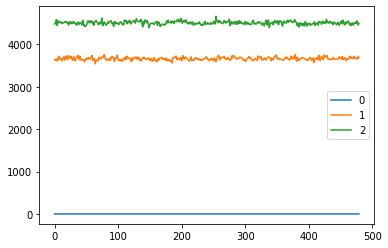

In [18]:
plot_falha(arquivos_treino[3])

In [17]:
def define_model(dropouts=[], lnormalize=False, r=1, thirdl=False, n_steps=None):
    """
    TODO: Ver como reduzir o overfitting do modelo
    """
    # definição da CNN
    m  = models.Sequential()
    # Convolutional layer com 32 neurônios
    if lnormalize:
        m.add(layers.Conv2D(int(64/r), (2, 2), activation='relu', input_shape=(13, 2, 2), name='conv1', kernel_regularizer=regularizers.l2(0.01)))
    else:
        m.add(layers.Conv2D(int(64/r), (2, 2), activation='relu', input_shape=(13, 2, 2), name='conv1'))
    m.add(layers.MaxPooling2D((2, 1), name='maxpooling1'))
    if dropouts[0]:
        m.add(layers.Dropout(0.4))
    if lnormalize:
        m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv2', 
            kernel_regularizer=regularizers.l2(0.01)))
    else:
        m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv2'))
    
    if thirdl:        
        m.add(layers.MaxPooling2D((2, 1), name='maxpooling2'))
        if dropouts[1]:
            m.add(layers.Dropout(0.4))
        if lnormalize:
            m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv3', 
                kernel_regularizer=regularizers.l2(0.01)))
        else:
            m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv3'))
    m.add(layers.Flatten())
    m.add(layers.Dense(int(32/r), activation='relu'))
    if thirdl:
        if dropouts[2]:
            m.add(layers.Dropout(0.2))
    # 21 classes: normal (0) e falha (XX)
    m.add(layers.Dense(2, name="previsoes"))

    lrf = optimizers.schedules.PiecewiseConstantDecay(
        [2*n_steps, 5*n_steps, 10*n_steps, 20*n_steps],
        [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
    )

    opt = optimizers.Adam(learning_rate=1e-4)
    #opt = optimizers.SGD()
    m.compile(optimizer=opt, loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return m

def plot_acc_loss(title, hist):
    fig, ax = plt.subplots(ncols=2, figsize=(8,3))
    ax[0].plot (hist.history['accuracy'], label='acc')
    ax[0].plot (hist.history['val_accuracy'], label='val_acc')
    ax[0].legend()
    ax[1].plot (hist.history['loss'], label='loss')
    ax[1].plot (hist.history['val_loss'], label='val_loss')
    ax[1].legend()
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    

In [29]:
print (1e-7)

1e-07


In [6]:
dnormal = pd.read_csv("data/d00.dat", delim_whitespace=True, header=None)
dnormal['falha'] = np.zeros(len(dnormal), dtype='int')
colunas = np.arange(52)

## Falha 3

In [22]:
falha=2
X_treino, labels_treino = get_entradas_labels_treino(dnormal, arquivos_treino[falha], colunas)
X_teste, labels_teste = get_entradas_labels_teste(arquivos_teste[falha], colunas)

In [8]:
lista_drops = [
    [0, 0, 0], [0, 0, 1], [0, 1, 1], [1, 1, 1], [1, 1, 0], [1, 0, 0], [1, 0, 1], [0, 1, 0]
]

lista_drops2 = [
    [0, 0], [0, 1], [1, 0], [1, 1]
]

Para as falhas [3, X, X]

Verifico alguns parâmetros e salvo o modelo com melhor acurácia.

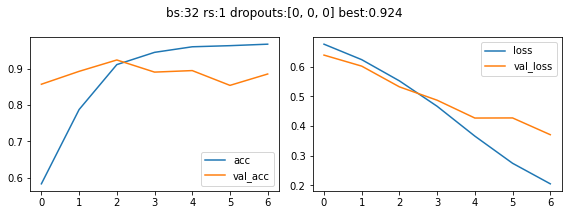

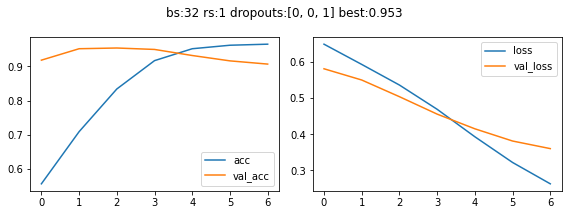

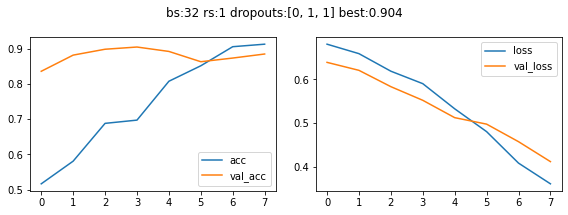

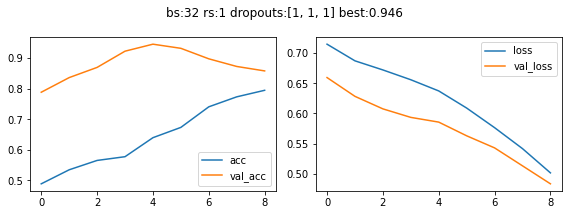

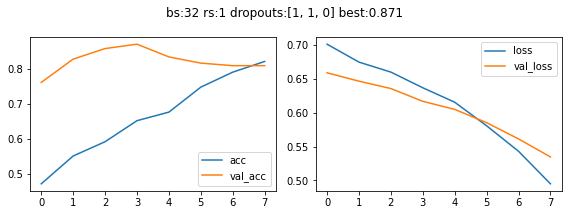

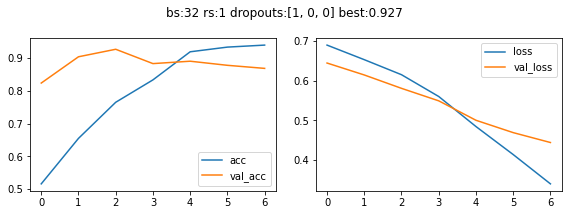

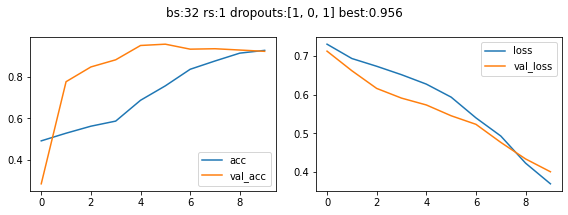

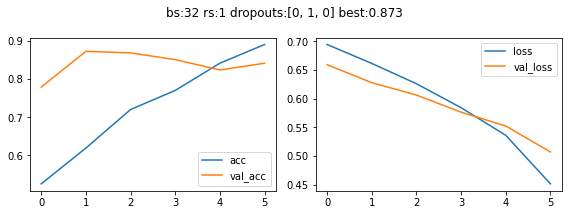

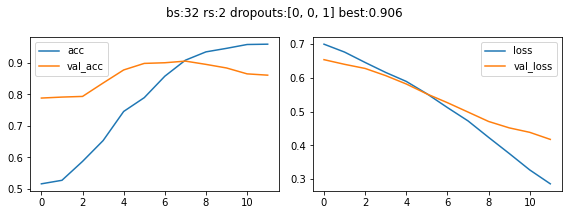

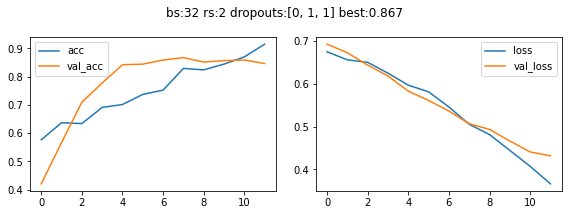

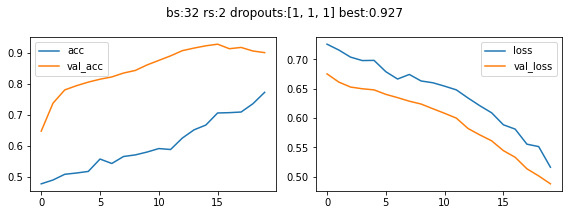

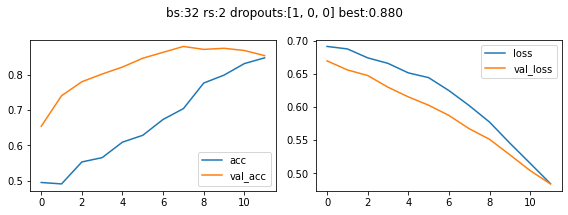

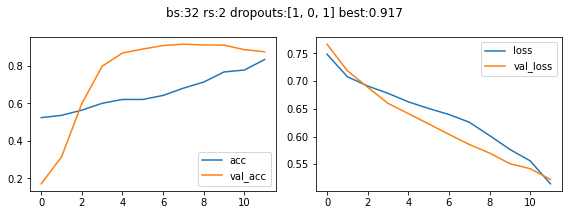

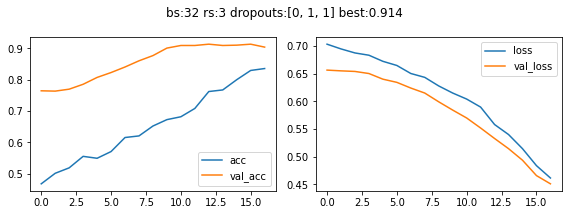

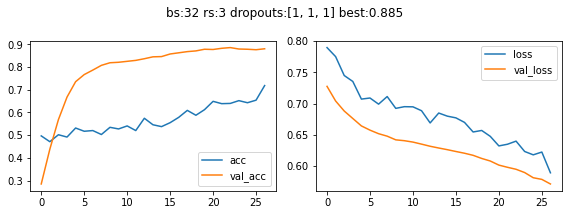

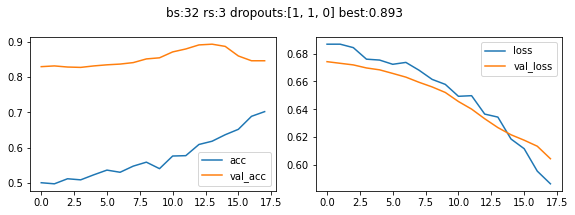

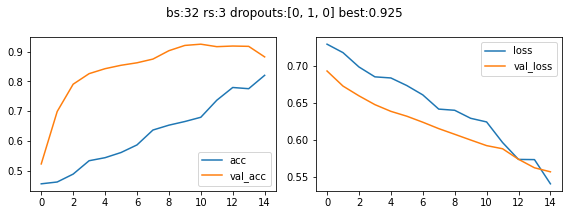

In [26]:
batch_sizes = [8]
batch_sizes = [32]
rs = [1,2,3]
es = True
b = 64
treshold = 85.0
for b in batch_sizes:    
    for r in rs:
        for ld in lista_drops:
            loss_monitor = callbacks.EarlyStopping(monitor='val_accuracy', patience=4, mode='max')
            n_steps = X_treino.shape[0]//b
            cnn = define_model(dropouts=ld, lnormalize=False, r=r, thirdl=True, n_steps=n_steps)
            if es:
                hist = cnn.fit(X_treino, labels_treino, batch_size=b, verbose=0, epochs=200, callbacks=[loss_monitor], validation_data=(X_teste, labels_teste))
            else:
                hist = cnn.fit(X_treino, labels_treino, batch_size=b, verbose=0, epochs=200)
            title = "bs:{} rs:{} dropouts:{} best:{:.3f}".format(b, r, ld, loss_monitor.best)
            if loss_monitor.best>0.85:
                plot_acc_loss(title, hist)           

In [25]:
loss_monitor.best>0.4

True

In [27]:
falha = 2
bs = 32
n_steps = X_treino.shape[0]//bs
monitor = [callbacks.EarlyStopping(monitor='val_accuracy', patience=4, 
                    mode='max', restore_best_weights=True),
           callbacks.ModelCheckpoint("modelos/f{}.h5".format(falha),monitor='val_accuracy', save_weights_only=True, 
                    mode='max', save_best_only=True)
           ]
for i in range(5):
    # falha 3
    # cnn = define_model(dropouts=[1,1], lnormalize=True, r=4, thirdl=False, n_steps=n_steps) 
    # falha2  
    # cnn = define_model(dropouts=[1,0,1], lnormalize=False, r=1, thirdl=True, n_steps=n_steps)  

    hist = cnn.fit(X_treino, labels_treino, verbose=0, batch_size=bs, epochs=200,
                validation_data=(X_teste, labels_teste), callbacks=[monitor])    
    print ("{} - best {}".format(i, monitor[0].best))         

0 - best 0.940
1 - best 0.933
2 - best 0.898
3 - best 0.842
4 - best 0.931


In [29]:
# carregando melhor modelo
cnn.load_weights("modelos/f2.h5")

In [30]:
labels_pred = np.argmax(cnn.predict(X_teste, verbose=0), axis=1)

In [31]:
accuracy_score(labels_pred, labels_teste)

0.9395833333333333